In [1]:
import numpy as np
import xarray as xr
import sys
import glob
import netCDF4 as nc
import os
import sys
import h5py
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from matplotlib.ticker import MaxNLocator


from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

# Inputs

In [2]:
load_path = '/Volumes/MyPassportForMac/MAC_15/NASA_project/2023/NEW_heatBudgetECCO_daily/data/outputs/tile8_single_heat_terms/'

number_of_levels = 9 # that corresponds to 10 levels
tile_number = 8
units_tag = 'W'
# Select maximum depth for plots
plot_ylim = -95 
full_time_period = False
combine_variables_tag = False


In [3]:
# Region tag for title in plots
title_tag = 'TASMAN' # SWP TASMAN

if title_tag == 'SWP':
    # Define box
    lon_min = 189.5 - 360
    lon_max = lon_min + 30
    lat_min = -45.5
    lat_max = lat_min + 20
elif title_tag == 'TASMAN':
    # Define box
    lon_min = 147 #- 360
    lon_max = lon_min + 8
    lat_min = -45
    lat_max = lat_min + 8

In [4]:
ECCO_metadata = ['XC_lon', 'YC_lat', 'Z_depth', 'vol', 'area']
# Create a dictionary to store the variables
ecco_data = {}
for ivar in ECCO_metadata:
    file_path = f"{load_path}/ECCOv4r4_{ivar}_1993_2017.nc"
    
    # Open the dataset and store it in the dictionary
    ecco_data[ivar] = xr.open_dataset(file_path)

# Access the variables using the dictionary
XC_lon = ecco_data['XC_lon'].sel(tile=tile_number)
YC_lat = ecco_data['YC_lat'].sel(tile=tile_number)
Z_depth = ecco_data['Z_depth'].Z_depth.sel(k=slice(None, number_of_levels))
vol = ecco_data['vol'].sel(tile=tile_number)
area = ecco_data['area'].sel(tile=tile_number)


In [5]:
if combine_variables_tag:
    # Define the variables to be saved
    varnames = ['G_total_tile8', 'G_advection_conv_tile8', 'G_diffusion_conv_tile8', 'G_forcing_tile8',
                'adv_hConv_tile8', 'adv_vConv_tile8', 'dif_hConv_tile8', 'dif_vConv_tile8',
                'G_advection_conv_zon_tile8', 'G_advection_conv_mer_tile8',
                'G_diffusion_conv_zon_tile8', 'G_diffusion_conv_mer_tile8',
                'DATA_tile8']
    # Create a dictionary to store the variable data
    variable_data = {}

    # Loop through the years from 1992 to 2017
    for year in np.arange(1992, 2018):
        folder_year = str(year)
        path_for_load = load_path + folder_year + '/'

        # Load each variable for the current year and store it in the dictionary
        for varname in varnames:
            file_path = f"{path_for_load}/ECCOv4r4_{varname}_{folder_year}.nc"

            # Load data for the current year and vertical levels (k)
            data_for_year = xr.open_dataset(file_path).sel(k=slice(None, number_of_levels))

            # Store the data in the dictionary
            if varname not in variable_data:
                variable_data[varname] = []

            variable_data[varname].append(data_for_year)

    # Combine data for each variable across all years
    combined_data = {}
    for varname, data_list in variable_data.items():
        combined_data[varname] = xr.concat(data_list, dim='time')

    # Convert the dictionary values into a list
    datasets_list = list(combined_data.values())

    # Merge the list of datasets into a single dataset
    combined_dataset_tile8 = xr.merge(datasets_list)
    # Now, variable_data contains a single xarray dataset for each variable containing data for all years.
    # You can access the data using variable names, for example: variable_data['G_total_tile8']
    combined_dataset_tile8.to_netcdf('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/tile8_single_heat_terms/combined_dataset_tile8.nc')


In [6]:
# Load combined file with all the variables from the HARD DRIVE
combined_dataset_tile8 = xr.open_dataset(load_path + 'combined_dataset_tile8.nc')


In [7]:
varnames = ['G_total_tile8', 'G_advection_conv_tile8', 'G_diffusion_conv_tile8', 'G_forcing_tile8',
            'adv_hConv_tile8', 'adv_vConv_tile8', 'dif_hConv_tile8', 'dif_vConv_tile8',
            'G_advection_conv_zon_tile8', 'G_advection_conv_mer_tile8',
            'G_diffusion_conv_zon_tile8', 'G_diffusion_conv_mer_tile8',
            'DATA_tile8']

In [8]:
# Create variables with specific names
for varname in varnames:
    new_var_name = f"{varname}_1992_2017_k0_k9"
    globals()[new_var_name] = combined_dataset_tile8[varname]
    

In [9]:
varnames_plot = ['G_total_tile8_1992_2017_k0_k9', 'G_advection_conv_tile8_1992_2017_k0_k9', 
                 'G_diffusion_conv_tile8_1992_2017_k0_k9', 'G_forcing_tile8_1992_2017_k0_k9',
                 'adv_hConv_tile8_1992_2017_k0_k9', 'adv_vConv_tile8_1992_2017_k0_k9', 
                 'dif_hConv_tile8_1992_2017_k0_k9', 'dif_vConv_tile8_1992_2017_k0_k9',
                 'G_advection_conv_zon_tile8_1992_2017_k0_k9', 'G_advection_conv_mer_tile8_1992_2017_k0_k9',
                 'G_diffusion_conv_zon_tile8_1992_2017_k0_k9', 'G_diffusion_conv_mer_tile8_1992_2017_k0_k9',
                 'DATA_tile8_1992_2017_k0_k9', 'XC_lon', 'YC_lat', 'Z_depth', 'vol', 'area']


## Extract data within specified bounds

In [10]:
var_data_dict = {}
# Iterate through varnames_plot
for ivar in varnames_plot:
    # Extract lon and lat coordinates from the respective variable
#     lon = globals()[ivar].coords['i'].values
#     lat = globals()[ivar].coords['j'].values
    
    # Extract data within specified bounds and store in the dictionary
    lat_bounds = np.logical_and(YC_lat.YC_lat > lat_min, YC_lat.YC_lat < lat_max)
    lon_bounds = np.logical_and(XC_lon.XC_lon > lon_min, XC_lon.XC_lon < lon_max)
    lat_lon_bounds = np.logical_and(lat_bounds, lon_bounds)
    
    # Store sliced data in the dictionary
    var_data_dict[ivar + '_box'] = globals()[ivar].where(lat_lon_bounds, np.nan)
    print(ivar + '_box')
    
    new_var_name = f"{ivar}_box"

    globals()[new_var_name] = var_data_dict[new_var_name]  # Fix the key used for dictionary access


G_total_tile8_1992_2017_k0_k9_box
G_advection_conv_tile8_1992_2017_k0_k9_box
G_diffusion_conv_tile8_1992_2017_k0_k9_box
G_forcing_tile8_1992_2017_k0_k9_box
adv_hConv_tile8_1992_2017_k0_k9_box
adv_vConv_tile8_1992_2017_k0_k9_box
dif_hConv_tile8_1992_2017_k0_k9_box
dif_vConv_tile8_1992_2017_k0_k9_box
G_advection_conv_zon_tile8_1992_2017_k0_k9_box
G_advection_conv_mer_tile8_1992_2017_k0_k9_box
G_diffusion_conv_zon_tile8_1992_2017_k0_k9_box
G_diffusion_conv_mer_tile8_1992_2017_k0_k9_box
DATA_tile8_1992_2017_k0_k9_box
XC_lon_box
YC_lat_box
Z_depth_box
vol_box
area_box


In [11]:
# G_total_tile8_1992_2017_k0_k9_box[6000:,1,:,:].plot()

In [12]:
# plt.figure(figsize=(10,10))
# # var_data_dict['G_total_tile8_1992_2017_k0_k9_box'][0,0,:,:].plot()
# G_total_tile8_1992_2017_k0_k9[0,0,:,:].plot()


In [13]:
varnames_plot = ['G_total_tile8_1992_2017_k0_k9_box', 'G_advection_conv_tile8_1992_2017_k0_k9_box', 'G_diffusion_conv_tile8_1992_2017_k0_k9_box', 'G_forcing_tile8_1992_2017_k0_k9_box',
            'adv_hConv_tile8_1992_2017_k0_k9_box', 'adv_vConv_tile8_1992_2017_k0_k9_box', 'dif_hConv_tile8_1992_2017_k0_k9_box', 'dif_vConv_tile8_1992_2017_k0_k9_box',
            'G_advection_conv_zon_tile8_1992_2017_k0_k9_box', 'G_advection_conv_mer_tile8_1992_2017_k0_k9_box',
            'G_diffusion_conv_zon_tile8_1992_2017_k0_k9_box', 'G_diffusion_conv_mer_tile8_1992_2017_k0_k9_box',
            'DATA_tile8_1992_2017_k0_k9_box']


## Calculate weighted average


In [14]:
for ivar in varnames_plot:
    print('Variable:', ivar)
    
    # Extract title_tag from ivar
#     title_tag = ivar.split('_')[-1]
    
    # Define the new variable name
    new_var_name = f"{ivar}_wgtd_avg_{title_tag}"
    
    # Calculate weighted average
    globals()[new_var_name] = (eval(ivar) * area_box.area).sum(["i", "j"]) / area_box.area.sum(["i", "j"])

    # Print the new variable name
    print('New Variable:', new_var_name)
    


Variable: G_total_tile8_1992_2017_k0_k9_box
New Variable: G_total_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: G_advection_conv_tile8_1992_2017_k0_k9_box
New Variable: G_advection_conv_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: G_diffusion_conv_tile8_1992_2017_k0_k9_box
New Variable: G_diffusion_conv_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: G_forcing_tile8_1992_2017_k0_k9_box
New Variable: G_forcing_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: adv_hConv_tile8_1992_2017_k0_k9_box
New Variable: adv_hConv_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: adv_vConv_tile8_1992_2017_k0_k9_box
New Variable: adv_vConv_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: dif_hConv_tile8_1992_2017_k0_k9_box
New Variable: dif_hConv_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: dif_vConv_tile8_1992_2017_k0_k9_box
New Variable: dif_vConv_tile8_1992_2017_k0_k9_box_wgtd_avg_TASMAN
Variable: G_advection_conv_zon_tile8_1992_2017_k0_k9_box
New Variable: G_advecti

## Plot depth vs time

### Define time range to plot

In [15]:
if full_time_period: 
    #Define time for plotting - FULL TIME SERIES
    plot_xlim_min = datetime.strptime("Jan 1 1993 01:00AM", '%b %d %Y %I:%M%p')
    plot_xlim_year_month_min = '1993_01'
    plot_xlim_max = datetime.strptime("Dec 31 2016 01:00AM", '%b %d %Y %I:%M%p')
    plot_xlim_year_month_max = '2016_12'    
else: 
    if title_tag == 'NEP':
        # Define time for plotting - BLOB REGION
        plot_xlim_min = datetime.strptime("Jan 1 2012 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_min = '2012_01'
        plot_xlim_max = datetime.strptime("Dec 31 2016 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_max = '2016_12'
    elif title_tag == 'SWP':
        # Define time for plotting - SW PACIFIC REGION
        plot_xlim_min = datetime.strptime("Jan 1 2009 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_min = '2009_01'
        plot_xlim_max = datetime.strptime("Dec 31 2013 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_max = '2013_12'    
#         plot_xlim_min = datetime.strptime("Jan 1 2005 01:00AM", '%b %d %Y %I:%M%p')
#         plot_xlim_year_month_min = '2005_01'
#         plot_xlim_max = datetime.strptime("Dec 31 2016 01:00AM", '%b %d %Y %I:%M%p')
#         plot_xlim_year_month_max = '2016_12' 
    elif title_tag == 'TASMAN':
        # Define time for plotting - SW PACIFIC REGION
        plot_xlim_min = datetime.strptime("Sep 1 2015 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_min = '2015_09'
        plot_xlim_max = datetime.strptime("Aug 31 2016 01:00AM", '%b %d %Y %I:%M%p')
        plot_xlim_year_month_max = '2016_08'  

In [16]:
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super(MidpointNormalize, self).__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
def ecco_plot_time_vs_depth_JS_auto_limits(ivar, ivar_tag, ivar_box_tag):
    # Remove seasonal cycle
    if ivar in ['DATA']:
        bfr = eval(ivar).transpose()
    else:
        bfr = eval(ivar + ivar_box_tag).transpose()
    climo=bfr.groupby('time.month').mean('time')
    bfr_anom=bfr.groupby('time.month')-climo
    bfr_2plot = eval('bfr'+ivar_tag)
#     if flag_density:
#         bfr_rho_cont = eval('RHOAnoma' + ivar_box_tag)# + ivar_tag) # density should be calculated just using the total
    fig = plt.figure(figsize=(15,6))
    
    clim_calc = max(np.abs(np.quantile(bfr_2plot,0)),np.abs(np.quantile(bfr_2plot,1)))
    mylevs = np.linspace(-clim_calc, + clim_calc, 61)
    norm = MidpointNormalize(midpoint=0)
    
    
    clim = 3e-6
    mylevs = np.linspace(-clim, clim, 31)
    
    
#     max_abs_var = max(max(bfr_2plot))
#     mylevs = np.linspace(-max_abs_var, max_abs_var, 31)
    # Plot variables
#     plt.contourf(bfr_anom.time, Z_depth, bfr_2plot, cmap=plt.cm.bwr)#, levels=mylevs, vmin=min(mylevs), vmax=max(mylevs), extend = 'both')
    plt.contourf(bfr_anom.time, Z_depth, bfr_2plot.values, cmap=plt.cm.bwr, levels=mylevs, norm=norm, vmin=min(mylevs), vmax=max(mylevs), extend = 'both')
#     print(Z_depth)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=12)
    # Plot rho countours with or without seasonal anomalies
#     if flag_density:
#         plt.contour(bfr_rho_cont.time, Z_depth, bfr_rho_cont.transpose()+1029, colors='k', levels=np.arange(1020,1028,.5), linewidths = 0.5)
    if ivar in ['ConvH_total_horiz']:
        plt.title(ivar.split('_tile8')[0] + ivar_tag +' (degC m3/s)' + ', ' + title_tag, fontsize = 14)
    else:
        plt.title(ivar.split('_tile8')[0] + ivar_tag + ' (' + units_tag + '), ' + title_tag, fontsize = 14)
    plt.ylim(plot_ylim,0) 
    plt.xlabel('Year', fontsize = 12)
    plt.xlim(plot_xlim_min, plot_xlim_max)
    plt.ylabel('Depth, m', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
    fig.tight_layout() 
#     if ivar_tag =='':
#         fig.savefig('./depth_vs_time_plots' + '/total/' + 'depth_vs_time_' \
#                     + ivar + '_' + title_tag + '_' + plot_xlim_year_month_min \
#                     + '_' + plot_xlim_year_month_max + ivar_tag + '.jpg', dpi = 900, bbox_inches='tight')
#     else:
#         fig.savefig('./depth_vs_time_plots' + '/anom/' + 'depth_vs_time_' \
#                     + ivar + '_' + title_tag + '_' + plot_xlim_year_month_min \
#                     + '_' + plot_xlim_year_month_max + ivar_tag + '.jpg', dpi = 900, bbox_inches='tight') 

### Actual plots


In [17]:
varnames_plot = ['G_total_tile8_1992_2017_k0_k9_box', 'G_advection_conv_tile8_1992_2017_k0_k9_box', \
                 'G_diffusion_conv_tile8_1992_2017_k0_k9_box', 'G_forcing_tile8_1992_2017_k0_k9_box']


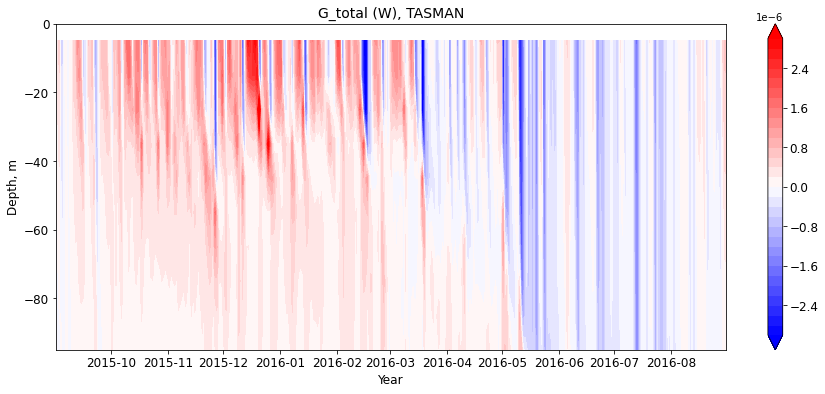

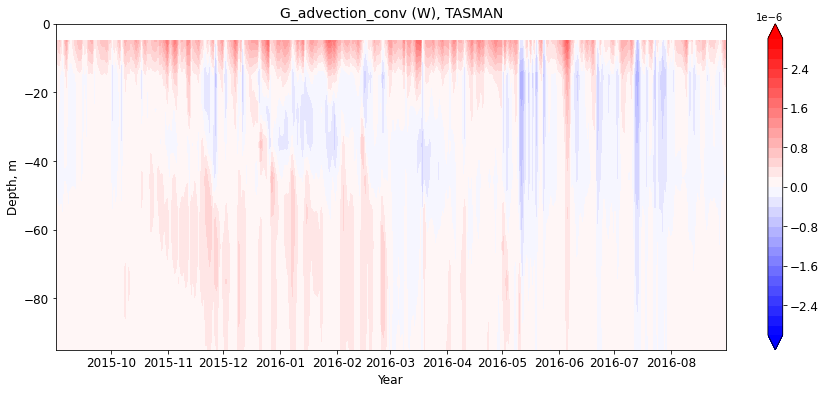

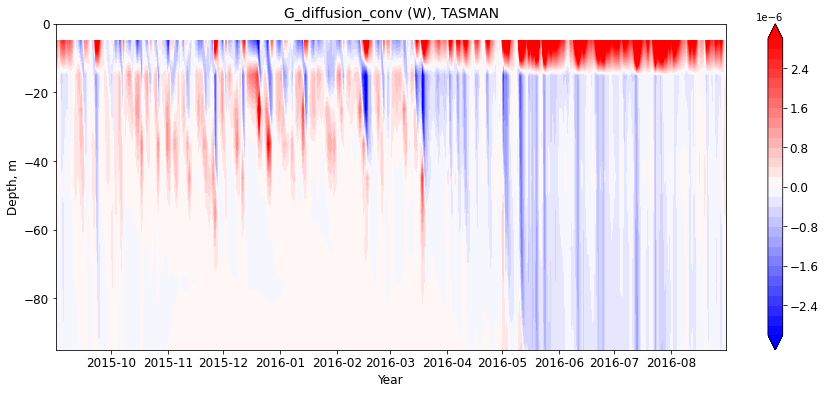

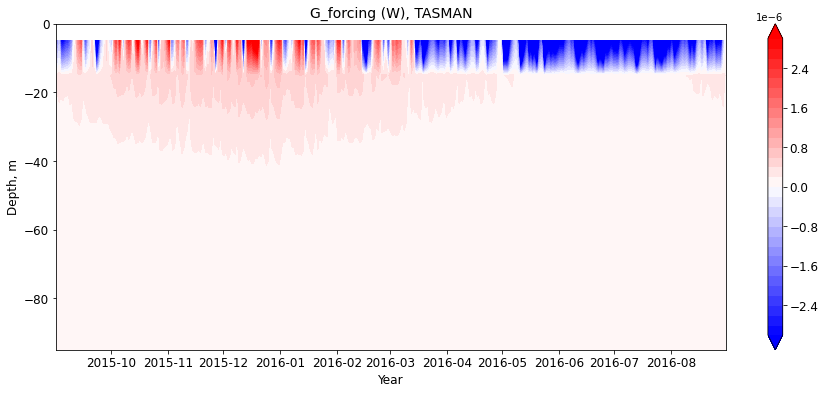

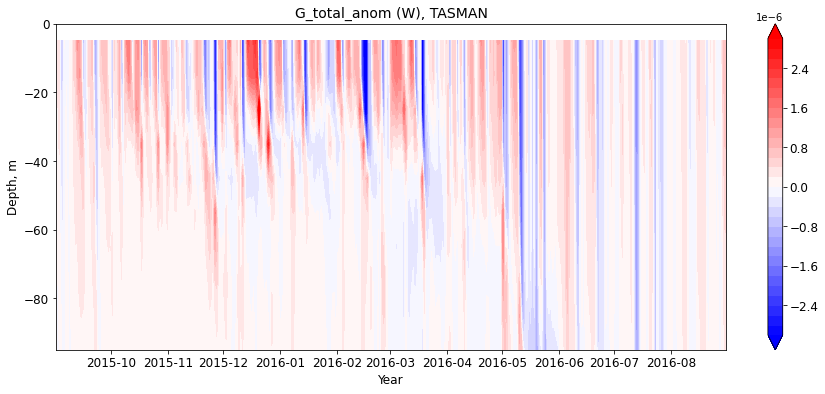

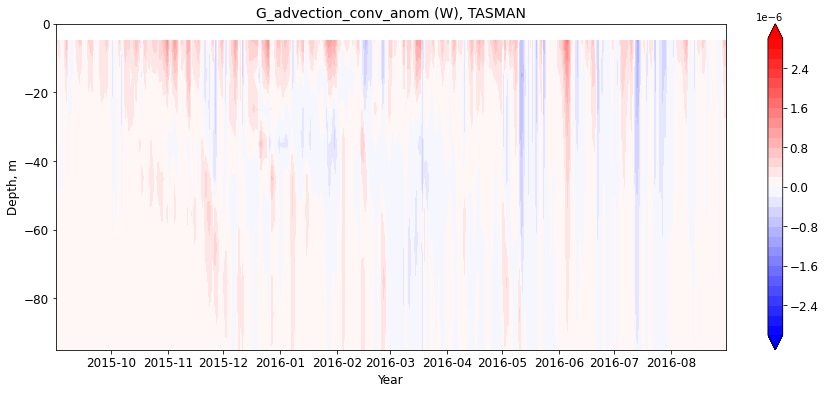

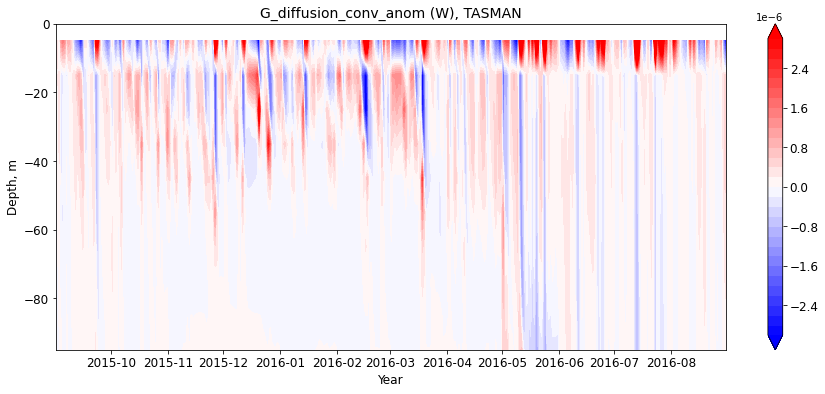

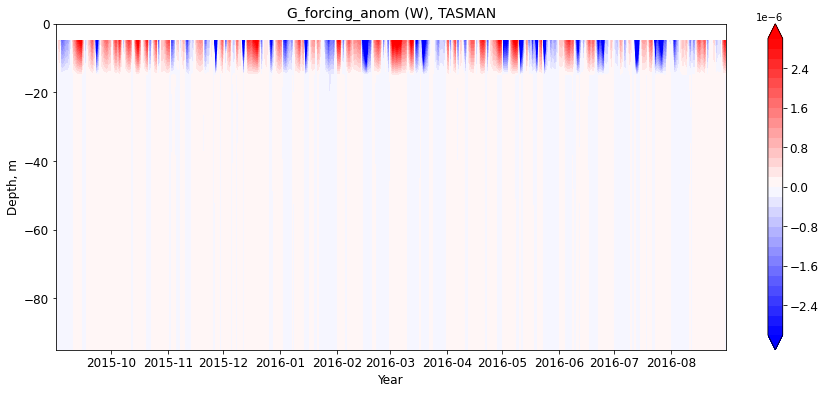

In [88]:
ivar_box_tag = '_wgtd_avg_' + title_tag

for ivar_tag in ['', '_anom']:
    for ivar in varnames_plot:
        # Avoid plots of non-relevant terms
        if (ivar not in ['time', 'XC_lon','YC_lat','Z_depth','vol','area']):
            ecco_plot_time_vs_depth_JS_auto_limits(ivar, ivar_tag, ivar_box_tag)
            

In [61]:
def ecco_plot_time_vs_depth_JS_cumulative_sum(ivar, ivar_tag, ivar_box_tag):
    # Remove seasonal cycle
    if ivar in ['DATA']:
        bfr = eval(ivar).transpose()
    else:
        bfr = eval(ivar + ivar_box_tag).transpose()
    climo = bfr.groupby('time.month').mean('time')
    bfr_anom = bfr.groupby('time.month') - climo

    # Calculate cumulative sum in time
    # Convert datetime64[ns] to int64 for cumsum
    bfr_anom['time'] = (bfr_anom['time'] - bfr_anom['time'][0]).astype('int64')

    # Calculate cumulative sum over the time axis
    cumulative_sum_data = bfr_anom.cumsum(dim='time')

    # Convert back to datetime64[ns] for plotting or further analysis
    cumulative_sum_data['time'] = xr.DataArray(cumulative_sum_data['time'].values.astype('datetime64[ns]'), dims='time')
    
    bfr_anom_cumul = cumulative_sum_data

    bfr_2plot = eval('bfr' + ivar_tag)

    # Plot variables
    fig = plt.figure(figsize=(15, 6))

    # Adjust clim_calc and mylevs based on cumulative sum behavior
#     clim_calc = max(abs(np.min(bfr_anom_cumul)), abs(np.max(bfr_anom_cumul)))
#     mylevs = np.linspace(-clim_calc, +clim_calc, 61)

#     clim_calc = max(np.abs(np.quantile(bfr_anom_cumul,0)),np.abs(np.quantile(bfr_anom_cumul,1)))
#     mylevs = np.linspace(-clim_calc, + clim_calc, 61)
#     mylevs = np.linspace(-1E-6, + 1E-6, 61)
    norm = MidpointNormalize(midpoint=0)
    
    plt.contourf(bfr_anom_cumul.time, Z_depth, bfr_anom_cumul.values,
                cmap=plt.cm.bwr)#, norm=norm, extend='both')

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=12)

    # Adjust title based on cumulative sum
    if ivar in ['ConvH_total_horiz']:
        plt.title(ivar.split('_tile8')[0] + ivar_tag + ' (cumulative degC m3/s)' + ', ' + title_tag, fontsize=14)
    else:
        plt.title(ivar.split('_tile8')[0] + ivar_tag + ' (cumulative ' + units_tag + '), ' + title_tag, fontsize=14)

    plt.ylim(plot_ylim, 0)
    plt.xlabel('Year', fontsize=12)
    plt.xlim(plot_xlim_min, plot_xlim_max)
    plt.ylabel('Depth, m', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    fig.tight_layout()
    ciao


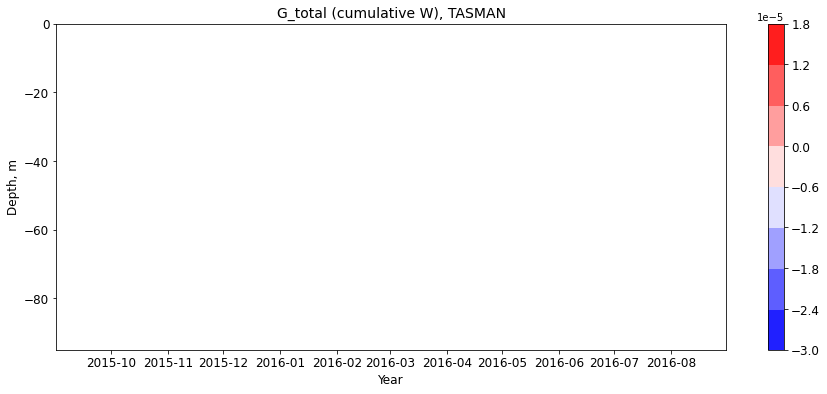

NameError: name 'ciao' is not defined

In [62]:
ivar_box_tag = '_wgtd_avg_' + title_tag

for ivar_tag in ['', '_anom']:
    for ivar in varnames_plot:
        # Avoid plots of non-relevant terms
        if (ivar not in ['time', 'XC_lon','YC_lat','Z_depth','vol','area']):
            ecco_plot_time_vs_depth_JS_cumulative_sum(ivar, ivar_tag, ivar_box_tag)

In [49]:
    clim_calc = max(np.abs(np.quantile(bfr_anom_cumul,0)),np.abs(np.quantile(bfr_anom_cumul,1)))
clim_calc

1.1455752377131521e-05

(16679.041666666668, 17044.041666666668)

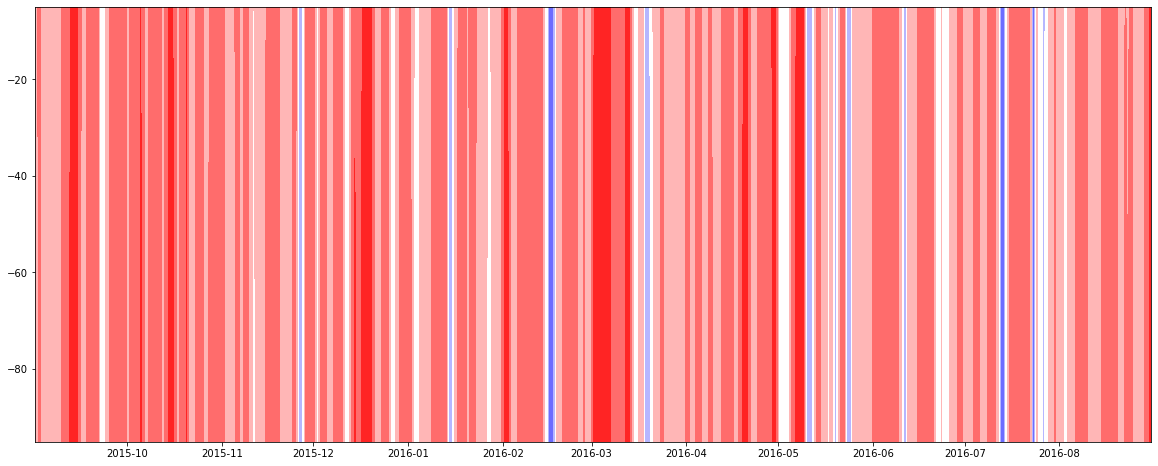

In [60]:
plt.figure(figsize=(20,8))
plt.contourf(bfr_anom_cumul.time, Z_depth, bfr_anom_cumul.values, cmap=plt.cm.bwr)
plt.xlim(plot_xlim_min, plot_xlim_max)


In [20]:
bfr = eval(ivar + ivar_box_tag).transpose()
climo = bfr.groupby('time.month').mean('time')
bfr_anom = bfr.groupby('time.month') - climo 

In [27]:
bfr_anom[0][0:10]

<xarray.DataArray (time: 10)>
array([ 5.59646342e-07,  9.85076666e-07, -7.08199573e-07, -2.84671758e-06,
       -3.41681790e-06, -1.14610783e-06, -6.66509245e-07,  2.45359877e-08,
       -6.29066776e-07, -1.14336340e-06])
Coordinates:
    k        int32 0
    tile     int32 8
  * time     (time) datetime64[ns] 1992-01-02T12:00:00 ... 1992-01-11T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1

In [22]:
bfr_anom_cumul = bfr_anom.cumsum(axis=0)

In [30]:
bfr_anom_cumul[0][0:10]

<xarray.DataArray (time: 10)>
array([ 5.59646342e-07,  9.85076666e-07, -7.08199573e-07, -2.84671758e-06,
       -3.41681790e-06, -1.14610783e-06, -6.66509245e-07,  2.45359877e-08,
       -6.29066776e-07, -1.14336340e-06])
Coordinates:
    k        int32 0
    tile     int32 8
  * time     (time) datetime64[ns] 1992-01-02T12:00:00 ... 1992-01-11T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1

In [31]:
your_dataarray = bfr_anom

# Convert datetime64[ns] to int64 for cumsum
your_dataarray['time'] = (your_dataarray['time'] - your_dataarray['time'][0]).astype('int64')

# Calculate cumulative sum over the time axis
cumulative_sum_data = your_dataarray.cumsum(dim='time')

# Convert back to datetime64[ns] for plotting or further analysis
cumulative_sum_data['time'] = xr.DataArray(cumulative_sum_data['time'].values.astype('datetime64[ns]'), dims='time')


In [32]:
cumulative_sum_data

<xarray.DataArray (k: 10, time: 9495)>
array([[ 5.59646342e-07,  1.54472301e-06,  8.36523434e-07, ...,
         3.05267490e-06,  3.99530968e-06,  1.96681050e-18],
       [-1.85343324e-07, -3.86030697e-07, -6.32585286e-07, ...,
         8.06389053e-08, -5.03893774e-08, -1.13163602e-18],
       [-1.18007297e-07, -2.49150132e-07, -4.09188286e-07, ...,
         5.33083079e-08, -3.06451022e-08,  6.01658090e-19],
       ...,
       [-8.80389768e-09, -1.80095173e-08, -2.94360985e-08, ...,
         3.65397044e-09, -2.45788105e-09,  3.89866766e-20],
       [-5.33471681e-09, -1.09128568e-08, -1.78367872e-08, ...,
         2.21412132e-09, -1.48935163e-09,  1.09419451e-20],
       [-3.22490386e-09, -6.59696011e-09, -1.07825637e-08, ...,
         1.33846437e-09, -9.00331918e-10, -1.51374052e-21]])
Coordinates:
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9
    tile     int32 8
  * time     (time) datetime64[ns] 1970-01-01 1970-01-02 ... 1995-12-30T06:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12